<a href="https://colab.research.google.com/github/shivengg87/AI-ML/blob/main/ANNwithpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
# PyTorch = deep learning engine
# Handles tensors (like NumPy arrays but GPU-accelerated)
import torch.nn as nn
# nn = neural network building blocks
# Contains layers like Linear, ReLU, Dropout, Loss functions
import torch.optim as optim
# optim = optimization algorithms
# Responsible for updating weights (Adam, SGD, RMSprop)
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Dataset → blueprint for custom datasets
# TensorDataset → quick way to wrap tensors as dataset
# DataLoader → feeds data in batches (mini-batch training)
import torch.nn.functional as F
# Functional API for neural network operations
# Provides:
# - activation functions (relu, sigmoid, softmax)
# - loss functions (mse_loss, cross_entropy)
# Used when you don't want to create layers as objects

In [18]:
# Set random seeds for reproducibility
# Reproducibility = same input + same code ⇒ same output
# We set random seeds to ensure reproducibility by controlling randomness in weight
# initialization, data shuffling, and GPU operations,
# so that experiments can be reliably compared and debugged.
np.random.seed(42) # Fixes random numbers generated by NumPy
torch.manual_seed(42) # Fixes randomness in PyTorch on CPU
if torch.cuda.is_available():
  torch.cuda.manual_seed(42) # Fixes randomness in PyTorch on GPU
## Why 42? 42 is a nerd tradition. Any integer works

In [19]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # It’s just a label that tells PyTorch: “All tensors and models should live here.”
print(f"Using device: {device}")

Using device: cuda


In [20]:
#STEP-1. DATA LOADING AND PREPROCESSING
# A dataset is a collection of data used to train and test the neural network.
# California Housing Dataset
# Load the California Housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name='MedianHouseValue')
#housing.data → input features (numbers)
#housing.target → house prices
#housing.feature_names → column names
#housing.DESCR → dataset description

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeatures:\n{X.columns.tolist()}")
print(f"\nFirst 5 samples:\n{X.head()}")
print(f"\nTarget variable (first 5): {y.head().values}")


Dataset shape: (20640, 8)
Number of samples: 20640
Number of features: 8

Features:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First 5 samples:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

Target variable (first 5): [4.526 3.585 3.521 3.413 3.422]


1. MedInc
   Mean: 3.87, Std: 1.90
2. HouseAge
   Mean: 28.64, Std: 12.59
3. AveRooms
   Mean: 5.43, Std: 2.47
4. AveBedrms
   Mean: 1.10, Std: 0.47
5. Population
   Mean: 1425.48, Std: 1132.46
6. AveOccup
   Mean: 3.07, Std: 10.39
7. Latitude
   Mean: 35.63, Std: 2.14
8. Longitude
   Mean: -119.57, Std: 2.00


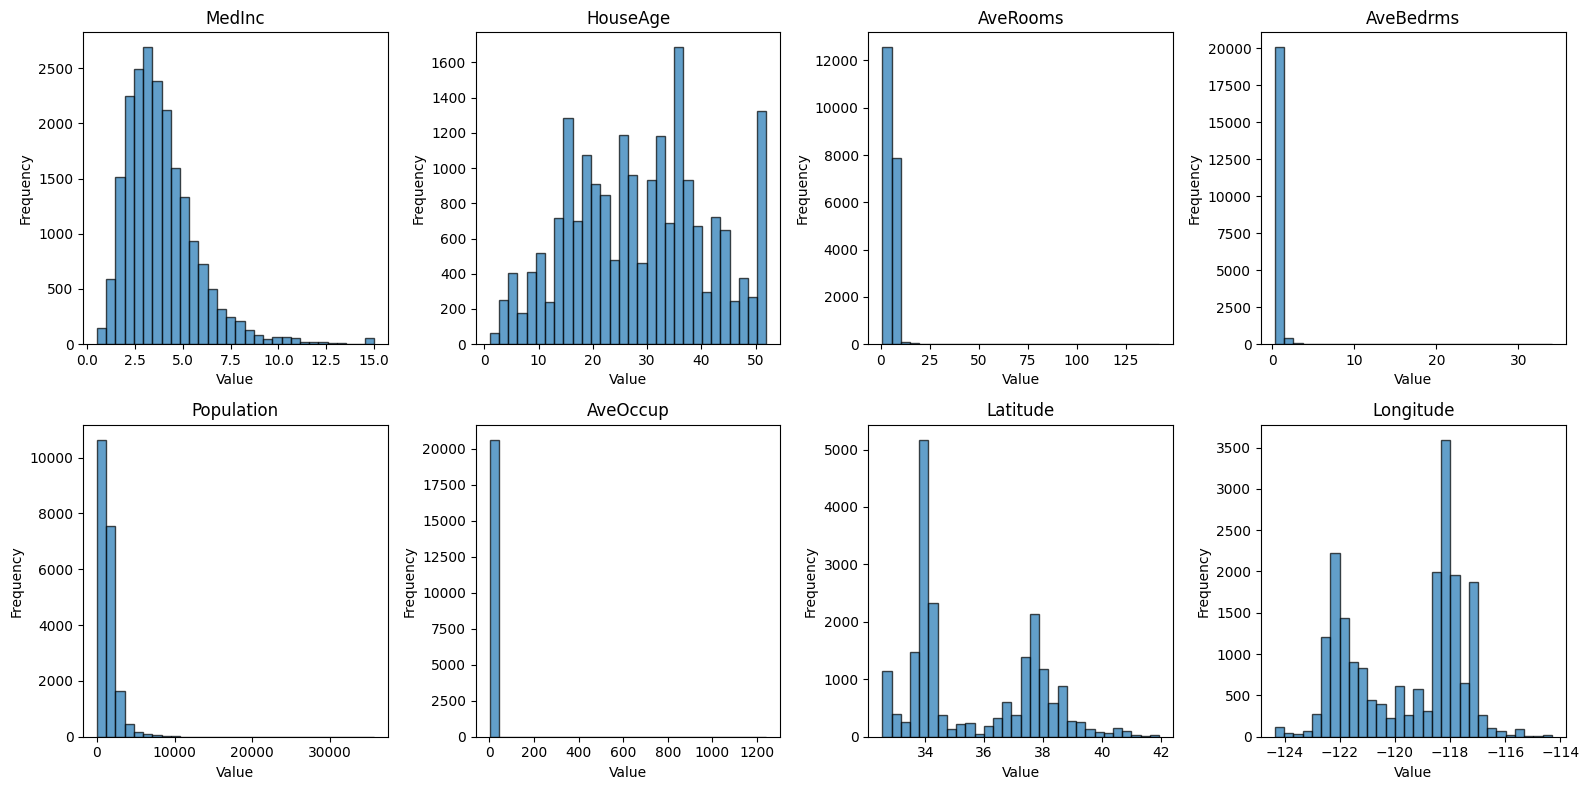

✓ Feature distributions visualized


In [22]:
# STEP-2 FEATURES (Input Variables)
# Features are the input variables that describe each sample.
# Below is just looping through each input feature.
for i, feature in enumerate(X.columns):
    print(f"{i+1}. {feature}")
    print(f"   Mean: {X[feature].mean():.2f}, Std: {X[feature].std():.2f}")
# X.columns → list of feature names
# enumerate → gives: i → index (0,1,2…) and feature → column name

# Visualize feature distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
# Creates a grid of plots: 2 rows × 4 columns = 8 plots
# figsize controls plot size (bigger = clearer)
# Why 2×4?  Because there are 8 features
axes = axes.ravel()
for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('pytorch_feature_distributions.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Feature distributions visualized")


In [23]:
# STEP-3: TRAIN-TEST SPLIT
# Splitting data to train the model and evaluate its performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Training set size: 16512 samples (80.0%)
Testing set size: 4128 samples (20.0%)


In [7]:
# Define ANN Architecture
class HousingANN(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer → Hidden layer
        self.fc1 = nn.Linear(8, 64)

        # Hidden layer → Hidden layer
        self.fc2 = nn.Linear(64, 32)

        # Hidden layer → Output layer
        self.output = nn.Linear(32, 1)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))   # first thinking stage
        x = self.relu(self.fc2(x))   # deeper thinking
        x = self.output(x)           # final prediction
        return x

In [8]:
# create model
model = HousingANN()

In [10]:
# Loss Function (Error Measurement)
criterion = nn.MSELoss()

In [11]:
# Optimizer (Gradient Descent Engine)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training Loop (Learning Happens Here)
epochs = 100
for epoch in range(epochs):

    # ---- Forward propagation ----
    predictions = model(X_train)

    # ---- Calculate loss ----
    loss = criterion(predictions, y_train)

    # ---- Backpropagation ----
    optimizer.zero_grad()  # clear old gradients
    loss.backward()        # compute gradients
    optimizer.step()       # update weights

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
# Model predicts-> Error calculated-> Error flows backward-> Weights updated-> Brain improves


Epoch [10/100], Loss: 4.9331
Epoch [20/100], Loss: 3.8435
Epoch [30/100], Loss: 2.8715
Epoch [40/100], Loss: 2.1009
Epoch [50/100], Loss: 1.5333
Epoch [60/100], Loss: 1.1545
Epoch [70/100], Loss: 0.9261
Epoch [80/100], Loss: 0.8047
Epoch [90/100], Loss: 0.7462
Epoch [100/100], Loss: 0.7096


In [13]:
# Testing (No Learning Here)
model.eval()   # switch to evaluation mode

with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)

print("Test Loss:", test_loss.item())

Test Loss: 0.7149856686592102


In [14]:
# Make a Real Prediction
sample_house = X_test[0]
predicted_price = model(sample_house).item()

print("Predicted price:", predicted_price * 100000)
print("Actual price   :", y_test[0].item() * 100000)

Predicted price: 83514.41025733948
Actual price   : 47699.99980926514
